# Raf-Rem-van Image Classifer

 ## Introduction

In this notebook, we train a convolutional neural network on a dataset consisting of .jpg's of Rafael, Rembrandt, and van Gogh paintings in order to produce a model to classify a painting as belonging to one of these three painters. The file `catalog.xlsx` contains records of paintings, `.jpg`s of which are hosted on www.wga.hu.

Let us begin by importing some standard and necessary packages.

In [2]:
import requests
import pandas as pd
import numpy as np
from PIL import Image
import random
import urllib
import math
from matplotlib import pyplot as plt

import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
 
img_width, img_height = 224, 224

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

import shutil

from sklearn.model_selection import train_test_split

 ## Prepping the data

Let's load the catalog of art pieces from www.wga.hu into the pandas dataframe `catalog`.

In [3]:
catalog = pd.read_excel('catalog.xlsx')

After inspecting the `html` code for www.wga.hu, the `.jpg`s of the paintings recorded in `catalog` can be retrieved from urls very similar to the urls stored in `catalog['URL']`. We add a column to `catalog` to record these urls.

In [4]:
catalog['IMG_URL']= catalog['URL']
for i in range(len(catalog)):
    catalog['IMG_URL'][i] = catalog['IMG_URL'][i].replace('/html/','/art/').replace('.html','.jpg')


We are interested in classifying paintings by their authors. Let us take a look at some of the most prolific painters in this catalog.

In [5]:
catalog.loc[catalog['FORM'] == 'painting']['AUTHOR'].value_counts()[:10]

GIOTTO di Bondone                 567
GOGH, Vincent van                 332
REMBRANDT Harmenszoon van Rijn    317
RUBENS, Peter Paul                308
RAFFAELLO Sanzio                  295
CRANACH, Lucas the Elder          291
TINTORETTO                        287
MICHELANGELO Buonarroti           278
TIZIANO Vecellio                  269
VERONESE, Paolo                   266
Name: AUTHOR, dtype: int64

Let's isolate these paintings and record the indices in `catalog` of the paintings that we are interested in.

In [6]:
painting_catalog = catalog.loc[catalog['FORM'] == 'painting']

van_gogh_paintings = list(painting_catalog.loc[painting_catalog['AUTHOR'] == 'GOGH, Vincent van'].index)
rembrandt_paintings = list(painting_catalog.loc[painting_catalog['AUTHOR'] == 'REMBRANDT Harmenszoon van Rijn'].index)
rafael_paintings = list(painting_catalog.loc[painting_catalog['AUTHOR'] == 'RAFFAELLO Sanzio'].index)
len(painting_catalog)

32438

The following cell will download all paintings in `painting_catalog` to a folder in the current working directory.

In [10]:
import os
cwd = os.getcwd()

if not os.path.exists(os.path.join(cwd, 'paintings from catalog')):
    os.makedirs(os.path.join(cwd, 'paintings from catalog'))
    
if not os.path.exists(os.path.join(cwd, 'train_dir')):
    os.makedirs(os.path.join(cwd, 'train_dir/rafael'))
    os.makedirs(os.path.join(cwd, 'train_dir/rembrandt'))
    os.makedirs(os.path.join(cwd, 'train_dir/van gogh'))
    
if not os.path.exists(os.path.join(cwd, 'test_dir')):
    os.makedirs(os.path.join(cwd, 'test_dir/rafael'))
    os.makedirs(os.path.join(cwd, 'test_dir/rembrandt'))
    os.makedirs(os.path.join(cwd, 'test_dir/van gogh'))

In [11]:
for i in rafael_paintings + rembrandt_paintings + van_gogh_paintings:
    urllib.request.urlretrieve(catalog['IMG_URL'][i], os.path.join(cwd, "paintings from catalog/" +str(catalog.index[i])+ ".jpg"))

Let us begin to preprocess our training data. Let us separate the paintings into training sets, which we will use to train our model, and holdout sets, which we will not use in training and reserve for validation of our model.

In [12]:
random.seed(1000)

van_gogh_train = random.sample(van_gogh_paintings, 278- 56)
van_gogh_holdout = [index for index in van_gogh_paintings if not(index in van_gogh_train)]

rembrandt_train = random.sample(rembrandt_paintings, 278-56)
rembrandt_holdout = [index for index in rembrandt_paintings if not(index in rembrandt_train)]

rafael_train = random.sample(rafael_paintings, 278-56)
rafael_holdout = [index for index in rafael_paintings if not(index in rafael_train)]


In [18]:
van_gogh_train, van_gogh_test = train_test_split(van_gogh_train, test_size = .3)
for i in van_gogh_train:
    shutil.copyfile(os.path.join(cwd, 'paintings from catalog/'+str(i)+'.jpg'), os.path.join(cwd, 'train_dir/van gogh/'+str(i)+'.jpg'))
for i in van_gogh_test:
    shutil.copyfile(os.path.join(cwd, 'paintings from catalog/'+str(i)+'.jpg'), os.path.join(cwd, 'test_dir/van gogh/'+str(i)+'.jpg'))
    
rembrandt_train, rembrandt_test = train_test_split(rembrandt_train, test_size = .3)
for i in rembrandt_train:
    shutil.copyfile(os.path.join(cwd, 'paintings from catalog/'+str(i)+'.jpg'), os.path.join(cwd, 'train_dir/rembrandt/'+str(i)+'.jpg'))
for i in rembrandt_test:
    shutil.copyfile(os.path.join(cwd, 'paintings from catalog/'+str(i)+'.jpg'), os.path.join(cwd, 'test_dir/rembrandt/'+str(i)+'.jpg'))
    
rafael_train, rafael_test = train_test_split(rafael_train, test_size = .3)
for i in rafael_train:
    shutil.copyfile(os.path.join(cwd, 'paintings from catalog/'+str(i)+'.jpg'), os.path.join(cwd, 'train_dir/rafael/'+str(i)+'.jpg'))
for i in rafael_test:
    shutil.copyfile(os.path.join(cwd, 'paintings from catalog/'+str(i)+'.jpg'), os.path.join(cwd, 'test_dir/rafael/'+str(i)+'.jpg'))

Our training data is somewhat thin; let's augment our training data by including all images generated by vertical and horizontal reflections.

In [19]:
for i in van_gogh_train:
    image = Image.open(os.path.join(cwd, 'train_dir/van gogh/'+str(i)+'.jpg'))
    vflip = image.transpose(method=Image.FLIP_TOP_BOTTOM)
    vflip.save(os.path.join(cwd, 'train_dir/van gogh/'+str(i)+'vflip.jpg'))
    hflip = image.transpose(method=Image.FLIP_LEFT_RIGHT)
    hflip.save(os.path.join(cwd, 'train_dir/van gogh/'+str(i)+'hflip.jpg'))
    hvflip = hflip.transpose(method=Image.FLIP_TOP_BOTTOM)
    hvflip.save(os.path.join(cwd, 'train_dir/van gogh/'+str(i)+'hvflip.jpg'))
    
for i in rembrandt_train:
    image = Image.open(os.path.join(cwd, 'train_dir/rembrandt/'+str(i)+'.jpg'))
    vflip = image.transpose(method=Image.FLIP_TOP_BOTTOM)
    vflip.save(os.path.join(cwd, 'train_dir/rembrandt/'+str(i)+'vflip.jpg'))
    hflip = image.transpose(method=Image.FLIP_LEFT_RIGHT)
    hflip.save(os.path.join(cwd, 'train_dir/rembrandt/'+str(i)+'hflip.jpg'))
    hvflip = hflip.transpose(method=Image.FLIP_TOP_BOTTOM)
    hvflip.save(os.path.join(cwd, 'train_dir/rembrandt/'+str(i)+'hvflip.jpg'))
    
for i in rafael_train:
    image = Image.open(os.path.join(cwd, 'train_dir/rafael/'+str(i)+'.jpg'))
    vflip = image.transpose(method=Image.FLIP_TOP_BOTTOM)
    vflip.save(os.path.join(cwd, 'train_dir/rafael/'+str(i)+'vflip.jpg'))
    hflip = image.transpose(method=Image.FLIP_LEFT_RIGHT)
    hflip.save(os.path.join(cwd, 'train_dir/rafael/'+str(i)+'hflip.jpg'))
    hvflip = hflip.transpose(method=Image.FLIP_TOP_BOTTOM)
    hvflip.save(os.path.join(cwd, 'train_dir/rafael/'+str(i)+'hvflip.jpg'))

 ## Training the model

We now construct the CNN classification model and start to train it. We use a simple, fully-trainable model that we build from scratch for this particular task. It stands to reason that this model could outperform a pretrained computer vision model such as ResNet, without the need for too much hyperparameter tuning, on this very niche task, but if this model underperforms, then we may try to train a pretrained head with a trainable fully connected layer on this task. 

In [36]:
train_data_dir = "C:/Users/jacob/van Gogh classifier/train_dir"
validation_data_dir = "C:/Users/jacob/van Gogh classifier/test_dir"

# Set the number of classes and other hyperparameters
num_classes = 3
input_shape = (224, 224, 3)
batch_size = 64
epochs = 100

# Data augmentation to reduce overfitting
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load and preprocess the training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and preprocess the validation data
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

# Create the model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Found 1860 images belonging to 3 classes.
Found 201 images belonging to 3 classes.
Epoch 1/100
29/29 [==============================] - 66s 2s/step - loss: 1.4346 - accuracy: 0.5206 - val_loss: 0.8054 - val_accuracy: 0.6406
Epoch 2/100
29/29 [==============================] - 76s 3s/step - loss: 0.7253 - accuracy: 0.6459 - val_loss: 0.7949 - val_accuracy: 0.5938
Epoch 3/100
29/29 [==============================] - 90s 3s/step - loss: 0.5508 - accuracy: 0.7678 - val_loss: 0.6383 - val_accuracy: 0.7656
Epoch 4/100
29/29 [==============================] - 93s 3s/step - loss: 0.4268 - accuracy: 0.8324 - val_loss: 0.9720 - val_accuracy: 0.7083
Epoch 5/100
29/29 [==============================] - 84s 3s/step - loss: 0.3903 - accuracy: 0.8474 - val_loss: 0.5238 - val_accuracy: 0.8125
Epoch 6/100
29/29 [==============================] - 83s 3s/step - loss: 0.3223 - accuracy: 0.8708 - val_loss: 0.7277 - val_accuracy: 0.7292
Epoch 7/100
29/29 [==============================] - 82s 3s/step - loss

KeyboardInterrupt: 

In [104]:
#Let's save the model
#model.save('raf_rem_vg_model.h5')

## Model Evaluation

Let's evaluate this model's performance on our holdout set. In the following cell, we load the holdout images in order to feed them to our model.

In [20]:
from tensorflow.keras.models import load_model
model = load_model('raf_rem_vg_model.h5')

In [21]:
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

van_gogh_holdout_images = [load('C:/Users/jacob/van Gogh classifier/paintings from catalog/'+str(i)+'.jpg') for i in van_gogh_holdout]
rafael_holdout_images = [load('C:/Users/jacob/van Gogh classifier/paintings from catalog/'+str(i)+'.jpg') for i in rafael_holdout]
rembrandt_holdout_images = [load('C:/Users/jacob/van Gogh classifier/paintings from catalog/'+str(i)+'.jpg') for i in rembrandt_holdout]

The call `model.predict(img)` returns a list of the model's estimates of the probabilities that `img` belongs to each of the three classes. For simplicity, we record the class with the highest probability as the model's prediction (with the understanding that class 0 is `'Rafael'`, class 1 is `'Rembrandt'`, and class 2 is `'van Gogh'`.

In [44]:
van_gogh_predictions = [max(enumerate(list(model.predict(img)[0])),key=lambda x: x[1])[0] for img in van_gogh_holdout_images]
rafael_predictions = [max(enumerate(list(model.predict(img)[0])),key=lambda x: x[1])[0] for img in rafael_holdout_images]
rembrandt_predictions = [max(enumerate(list(model.predict(img)[0])),key=lambda x: x[1])[0] for img in rembrandt_holdout_images]

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 50ms/step


In the following cells, we will compute the F1 score, precision, recall, and confusion matrix associated to this set of predictions.

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [45]:
y_pred = rafael_predictions + rembrandt_predictions + van_gogh_predictions
y_act = [0]*len(rafael_predictions) + [1]*len(rembrandt_predictions) + [2]*len(van_gogh_predictions)
cf = confusion_matrix(y_act, y_pred)

In [46]:
score = f1_score(
    y_act,
    y_pred,
    labels=[y_act[i] == y_pred[i] for i in range(len(y_act))],
    average='macro',
)
precision = precision_score(
    y_act,
    y_pred,
    labels=[y_act[i] == y_pred[i] for i in range(len(y_act))],
    average='macro',
)
recall = recall_score(
    y_act,
    y_pred,
    labels=[y_act[i] == y_pred[i] for i in range(len(y_act))],
    average='macro',
)

F1 score: 0.9405647191075224
Precision: 0.9173741007194246
Recall: 0.9649619021437503


<Axes: >

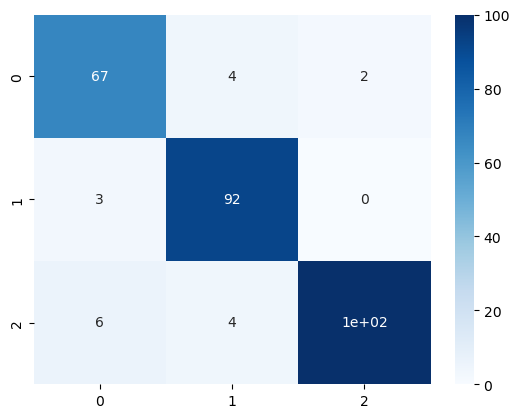

In [47]:
import seaborn as sns

print('F1 score: ' + str(score))
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))

sns.heatmap(cf, annot=True, cmap='Blues')

There is definitely room for improvement, but for a first pass this model appears to perform pretty well! We note here that class-wise recall is maximized by Rembrandt, and class-wise precision is maximized by van Gogh. Possible explanations for these, assuming that our model captures something meaningful, is that Rembrandt's style is the most recognizable of the three, hence the model is good at recognizing a Rembrandt painting as a Rembrandt, and that van Gogh's style is the most distinctive of the three, hence the model is less likely to assign `'van Gogh'` to a non-van Gogh painting. Let's view the misidentified paintings and compare them to a sample of their predicted author's work.

In [29]:
raf0 = [rafael_holdout[i] for i in range(len(rafael_holdout)) if rafael_predictions[i] == 0]
raf1 = [rafael_holdout[i] for i in range(len(rafael_holdout)) if rafael_predictions[i] == 1]
raf2 = [rafael_holdout[i] for i in range(len(rafael_holdout)) if rafael_predictions[i] == 2]

rem0 = [rembrandt_holdout[i] for i in range(len(rembrandt_holdout)) if rembrandt_predictions[i] == 0]
rem1 = [rembrandt_holdout[i] for i in range(len(rembrandt_holdout)) if rembrandt_predictions[i] == 1]
rem2 = [rembrandt_holdout[i] for i in range(len(rembrandt_holdout)) if rembrandt_predictions[i] == 2]

van0 = [van_gogh_holdout[i] for i in range(len(van_gogh_holdout)) if van_gogh_predictions[i] == 0]
van1 = [van_gogh_holdout[i] for i in range(len(van_gogh_holdout)) if van_gogh_predictions[i] == 1]
van2 = [van_gogh_holdout[i] for i in range(len(van_gogh_holdout)) if van_gogh_predictions[i] == 2]

In [40]:
def display_one_painting(index, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(Image.open('C:/Users/jacob/van Gogh classifier/paintings from catalog/'+str(index)+'.jpg'))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_paintings(images, title = None, predictions=None):
    if len(images) == 0:
        return
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
        
    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    if int(math.sqrt(len(images))) == math.sqrt(len(images)):
        rows = int(math.sqrt(len(images)))
        cols = int(math.sqrt(len(images)))
    else:
        rows = int(math.sqrt(len(images)))
        cols = len(images)//rows + 1
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, image in enumerate(images):
        title = ''
        correct = True
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_painting(image, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.suptitle(title)
    plt.show()


Here we show a sample of Rafael paintings. Note that, generally speaking, Rafael's paintings feature an abundance of fleshy and earthy tones (orange and brown), generally depict people (often groups of people), and often these people are situated amongst recognizable architectural features containing gray tones (cement/concrete/stone). Note also that the clothing worn by Rafael's subjects contains bright, bold colors in contrast with the subject's environment (and often with other articles of clothing in the painting).

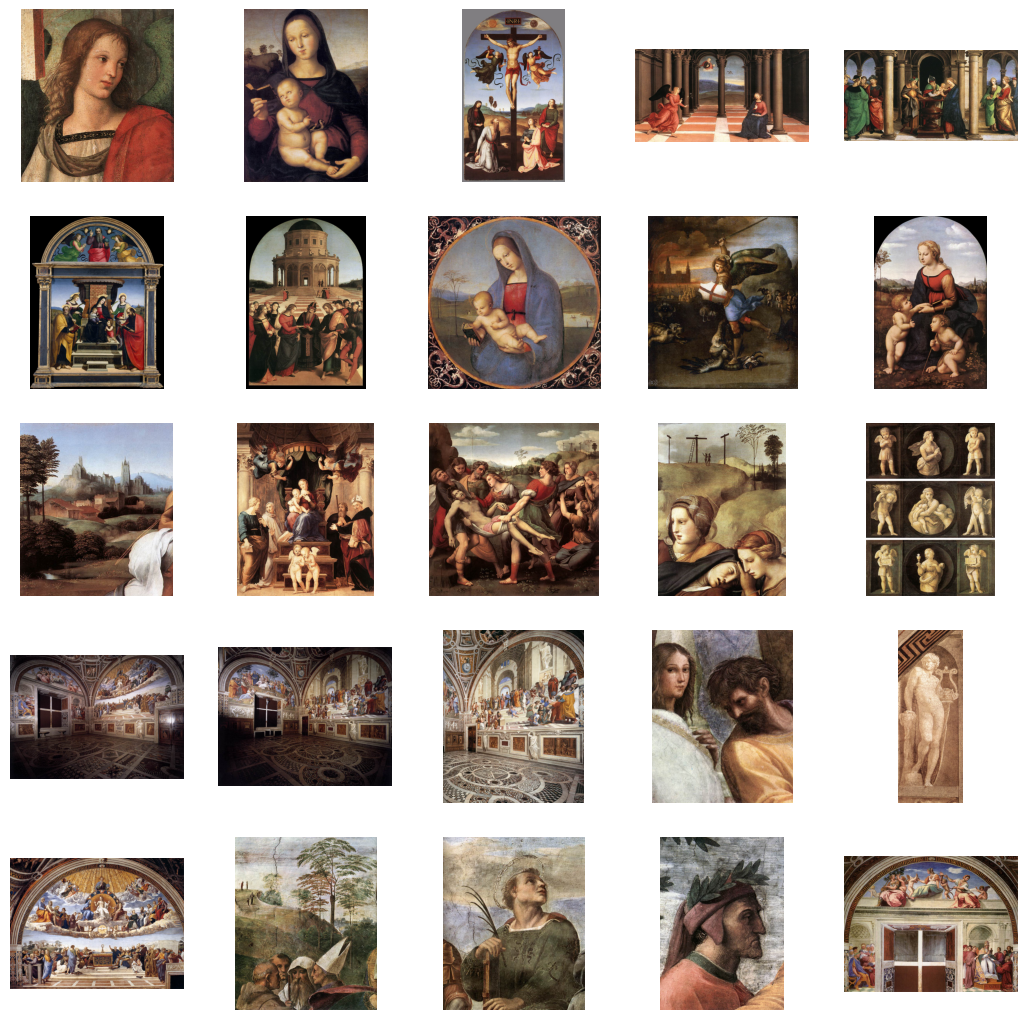

In [31]:
display_paintings(raf0[:25])

Here we show the Rembrandt paintings that the model mistook for Rafael paintings.

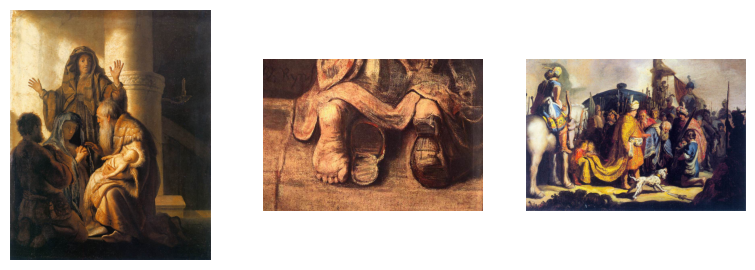

In [32]:
display_paintings(rem0)

Now we show the van Gogh paintings mistaken for Rafaels.

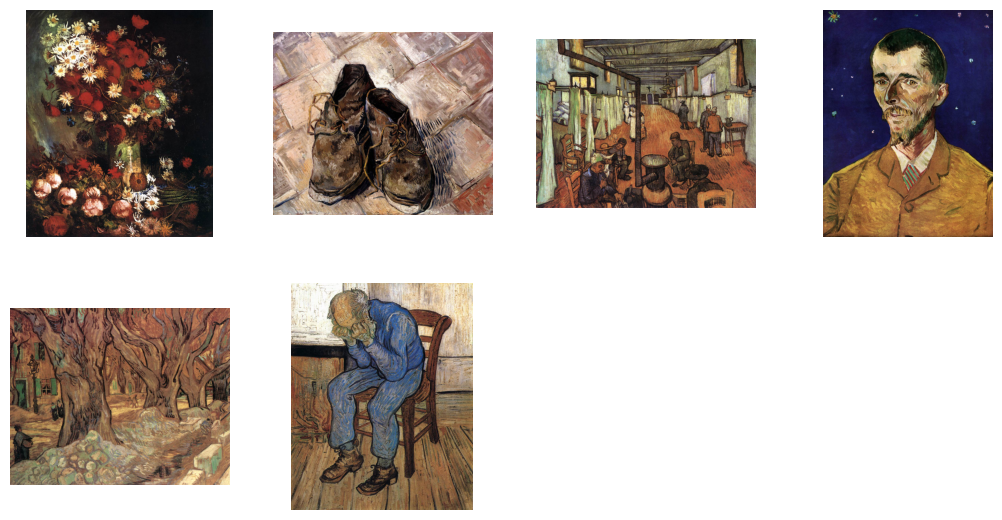

In [33]:
display_paintings(van0)

At least in terms of subject matter and color palette, these misidentified Rembrandts and van Goghs are very similar to the sample of Rafael paintings above.

Let's now look at a sample of Rembrandts. One immediately notices that Rembrandt's paintings feature an abundance of dark tones (especially black around the borders of the paintings). These paintings are generally portraits of somber subjects without much decoration, and the subjects' clothes are darker than Rafael's subjects clothes.

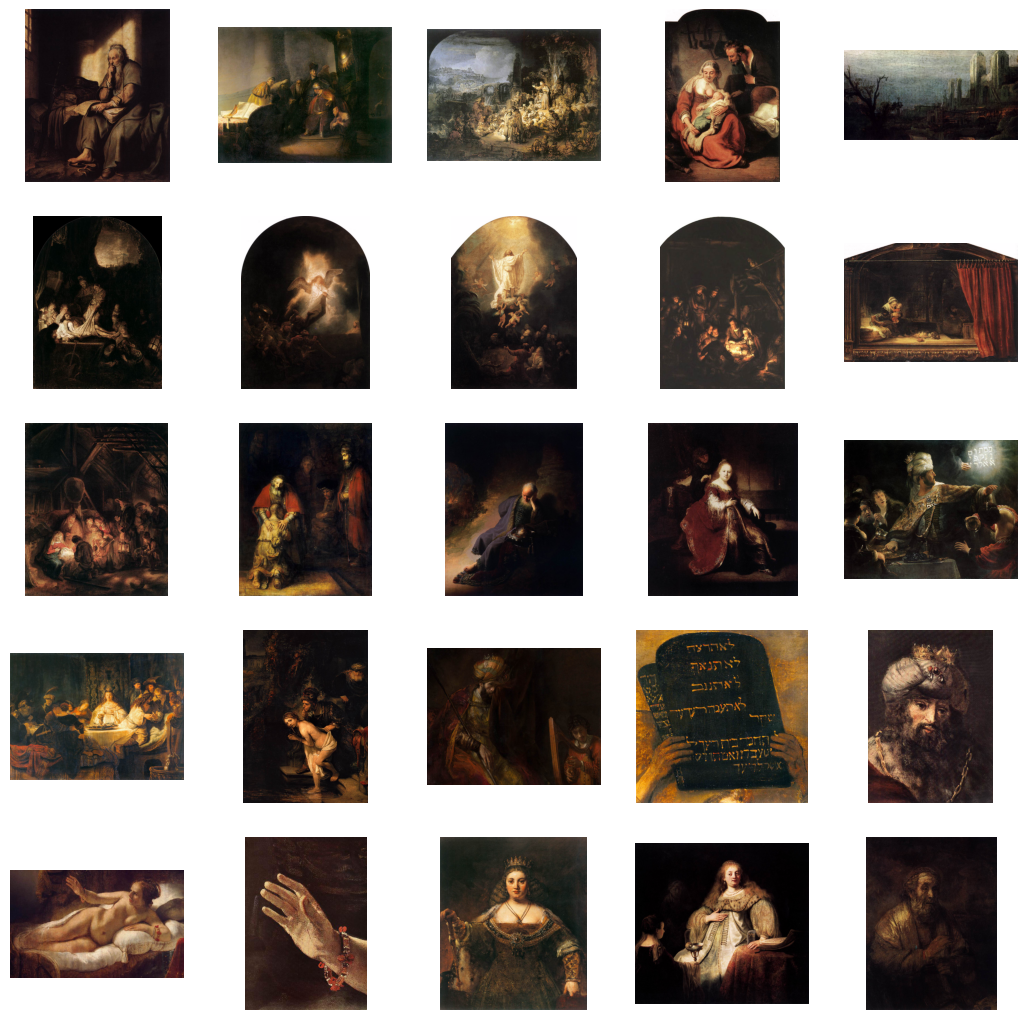

In [34]:
display_paintings(rem1[:25])

Apart from the first painting below, all of these misidentified Rafaels could easily be mistaken for Rembrandts by even a human with some knowledge of art history. It would be interesting to see the full list of probabilities that the model predicted for the second painting$-$perhaps it was a close call?

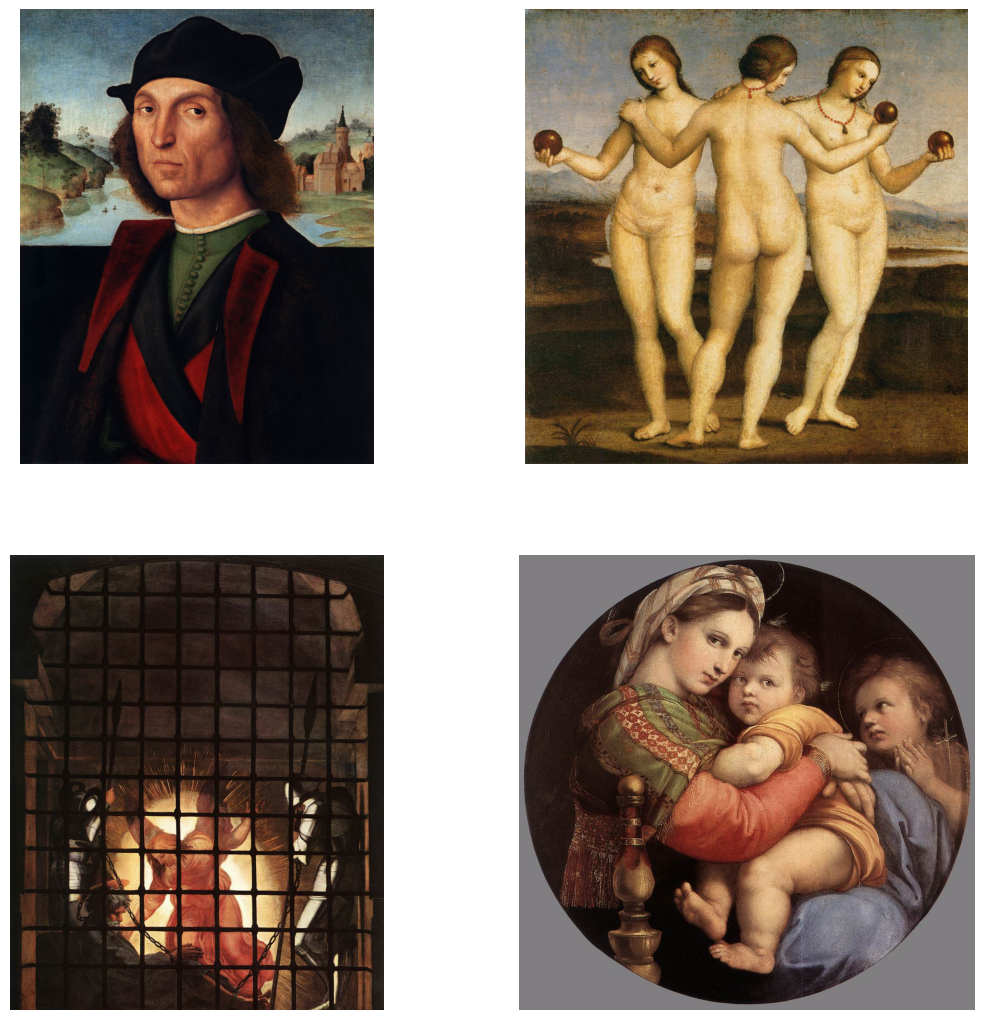

In [35]:
display_paintings(raf1)

Notwithstanding van Gogh's signature wobbly lines and viscous objects, a human could also very well mistake these paintings for Rembrandts.

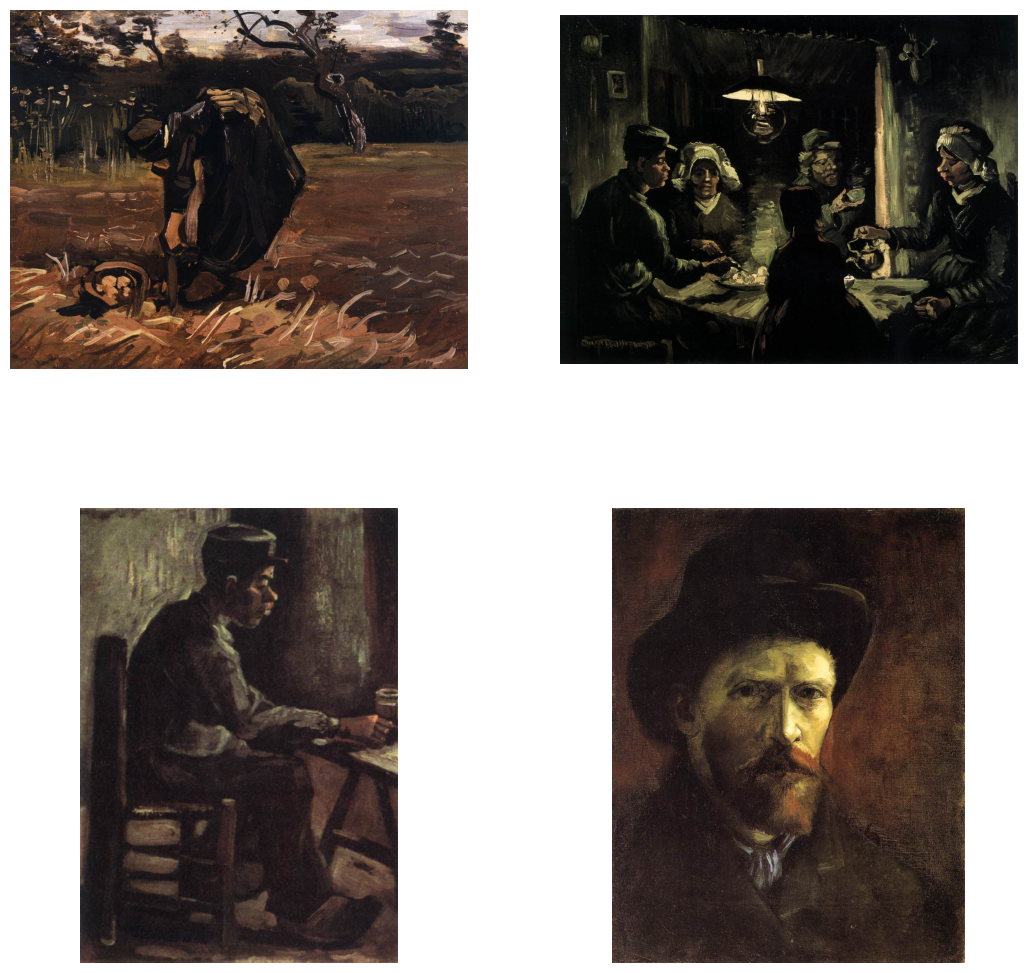

In [36]:
display_paintings(van1)

Finally, let us look at a sample of van Gogh paintings. These paintings are notably different from the Rafael and Rembrandt samples observed above. First, one notices an abundance of blue and green tones, and upon inspection this can be accounted for by van Gogh's apparent affinity for painting landscapes featuring lush vegetation against an open sky. However, even van Gogh's portraits include blues and greens nestled in his subjects' skin. 

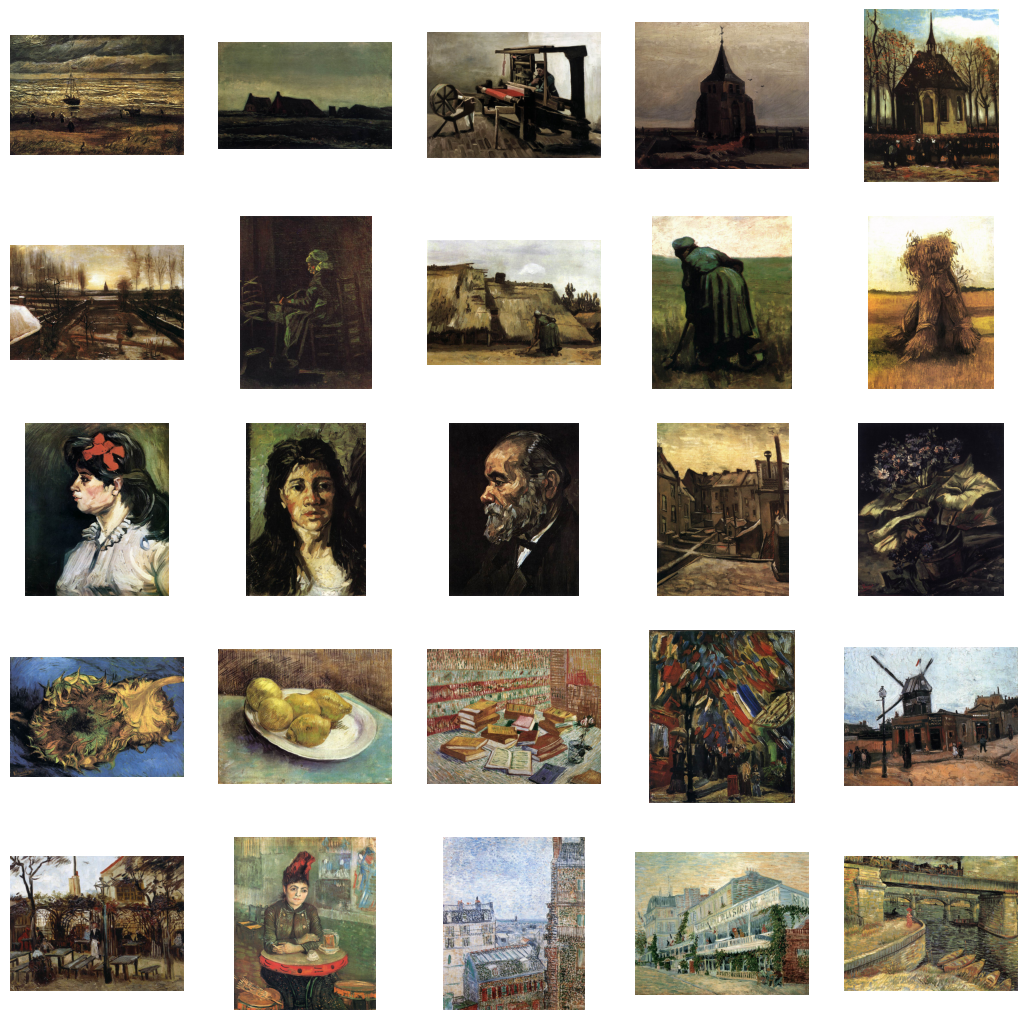

In [37]:
display_paintings(van2[:25])

Here are the Rafael's that the model misidentified as van Goghs. Notice the abundance of blues and greens.

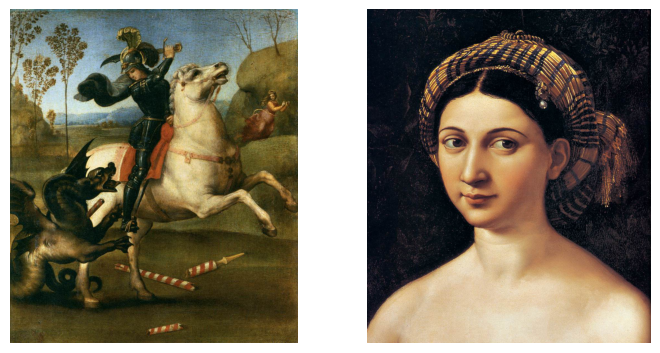

In [38]:
display_paintings(raf2)

Like the Rafaels in the previous cell, these misidentified Rembrandts feature a lot of blue and green. (** In my second iteration, `rem2` is an empty list.) 

In [41]:
display_paintings(rem2)

 ## Conclusion

Without examining the model's weights, it is impossible to know by what mechanism the model assigns probabilities. Inspection of the holdout data, and in particular the misidentifications, provides some insight into what the model could be paying attention to. The styles of the three painters that this model trained on are quite distinct from each other, so it stands to reason that in order to generalize this model to be able to handle more than just Rafael, Rembrandt, and van Gogh paintings, one must perform more hyperparameter tuning, and consider using a pretrained computer vision head. 